In [253]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
import pandas as pd
import os
from dotenv import load_dotenv
import time
from collections import Counter
import random
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score, precision_score,recall_score,confusion_matrix,classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import InputLayer,Conv2D,MaxPooling2D,MaxPool2D,Flatten,Dense,Dropout
from tensorflow.keras.preprocessing import image as IMG

In [254]:
with open('image_data_array.pickle','rb') as file:
    data = pickle.load(file)
    

In [248]:
X_train, X_test,X_val,y_train,y_test,y_val = data[0],data[1],data[2],data[3],data[4],data[5]

#Split data into train and validation set
#X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,random_state = 17,shuffle =True,test_size =.2)

y_train_hotcode = keras.utils.to_categorical(y_train)
y_val_hotcode = keras.utils.to_categorical(y_val)
y_test_hotcode = keras.utils.to_categorical(y_test)

In [255]:
IMGgen = IMG.ImageDataGenerator(
        #featurewise_center=True,
        #featurewise_std_normalization=True,
        #rescale=1./255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)


train_ds = IMGgen.flow(X_train, y_train, batch_size=32)
val_ds = IMGgen.flow(X_val, y_val, batch_size=16)

# Transfer Learning with Xception 

## Freeze Xception parameter and exclude top layers

In [256]:
Xception_base = keras.applications.Xception(weights="imagenet", 
                                            input_shape=(150, 150, 3),
                                            include_top=False) 

Xception_base.trainable = False

In [258]:
if os.path.exists("model_h5_file/Xception_model_array.h5") == False:
    

    inputs = keras.Input(shape=(150, 150, 3))

    #x = data_augmentation(inputs)  # Apply random data augmentation
    
    x = keras.applications.xception.preprocess_input(inputs)
    x = Xception_base(x, training=False)
    
    x = Flatten()(x)
    x = keras.layers.Dense(32)(x)
    x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
    x = keras.layers.Dense(32)(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(32)(x)
    x = keras.layers.Dropout(0.2)(x)
    outputs = keras.layers.Dense(8)(x)
    Xception = keras.Model(inputs, outputs)

    Xception.summary()



    Xception.compile(
        #loss='categorical_crossentropy',
        loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        #optimizer= keras.optimizers.Adam(learning_rate=0.01),
        optimizer = 'Adam',
        metrics=['accuracy'],
    )



    Xception_result = Xception.fit(train_ds,
                                validation_data= val_ds,
                                epochs=30, verbose=1, 
                                callbacks = keras.callbacks.EarlyStopping(patience=5))  # track progress as we fit

    time2 = time.time()
    Xception.save("model_h5_file/Xception_model_array.h5")
    with open('Xception_result.pickle','wb')as file:
        pickle.dump(Xception_result, file)

else: 
    Xception = keras.models.load_model('model_h5_file/Xception_model_array.h5')
        
    with open('Xception_result.pickle','rb') as file:
        Xception_result = pickle.load(file)

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_43 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 tf.math.truediv_6 (TFOpLamb  (None, 150, 150, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_6 (TFOpLam  (None, 150, 150, 3)      0         
 bda)                                                            
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense_51 (Dense)            (None, 32)                163

/Users/kristy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


INFO:tensorflow:Assets written to: ram://5c241b16-9838-49d0-a1e1-a0384d46b66e/assets


/Users/kristy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/Users/kristy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [259]:
#Xception= keras.models.load_model('model_h5_file/Xception_model_array.h5')
y_pred = np.argmax(Xception.predict(X_test),axis =1)

In [260]:
print("accuracy :",accuracy_score(y_test, y_pred))
print('recall :',recall_score(y_test,y_pred,average = 'macro'))
print('precision :', precision_score(y_test,y_pred,average = 'macro'))
print('f1 :', f1_score(y_test,y_pred,average = 'macro'))

accuracy : 0.8085569253081943
recall : 0.8085844894646969
precision : 0.8432986937995359
f1 : 0.8232385546856659


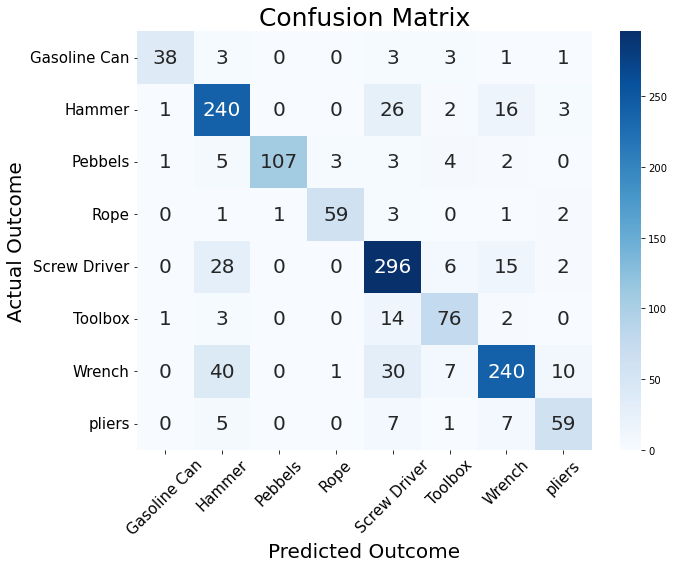

In [261]:
plt.figure(figsize=(10,8))
#plt.subplot(131)
ax = sns.heatmap(confusion_matrix(y_test,y_pred),
            annot = True, annot_kws={"size":20}, fmt="d",cmap = "Blues")

plt.title('Confusion Matrix', size=25)
plt.xlabel('Predicted Outcome', size=20)
plt.ylabel('Actual Outcome', size=20)
labels = [ int_category_map.get(key) for key in sorted(int_category_map.keys())]
ax.set_xticklabels(labels, size=15,rotation = 45)
ax.set_yticklabels(labels, size=15,rotation = 0)
plt.tight_layout()
plt.show();

##  Train Xception parameters

In [538]:
if os.path.exists('model_h5_file/Xception_model_array_trainable.h5') == False:
    Xception_base.trainable = True
    Xception.summary()

    Xception.compile(
        optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
        loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])
    
    Xception_base_trainable_result = Xception.fit(train_ds,
                                                 validation_data= val_ds, 
                                                  epochs=20, 
                                                  verbose=1,
                                                  batch_size =32,
                                                 callbacks = keras.callbacks.EarlyStopping(patience=2) )  # track progress as we fit
    Xception.save("model_h5_file/Xception_model_array_trainable.h5")

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_43 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 tf.math.truediv_6 (TFOpLamb  (None, 150, 150, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_6 (TFOpLam  (None, 150, 150, 3)      0         
 bda)                                                            
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense_51 (Dense)            (None, 32)                163

In [540]:
y_pred = np.argmax(Xception.predict(X_test),axis =1)
print("accuracy :",accuracy_score(y_test, y_pred))
print('recall :',recall_score(y_test,y_pred,average = 'macro'))
print('precision :', precision_score(y_test,y_pred,average = 'macro'))
print('f1 :', f1_score(y_test,y_pred,average = 'macro'))

accuracy : 0.8179840464104423
recall : 0.8176205087392772
precision : 0.845593934208118
f1 : 0.8302774563570348


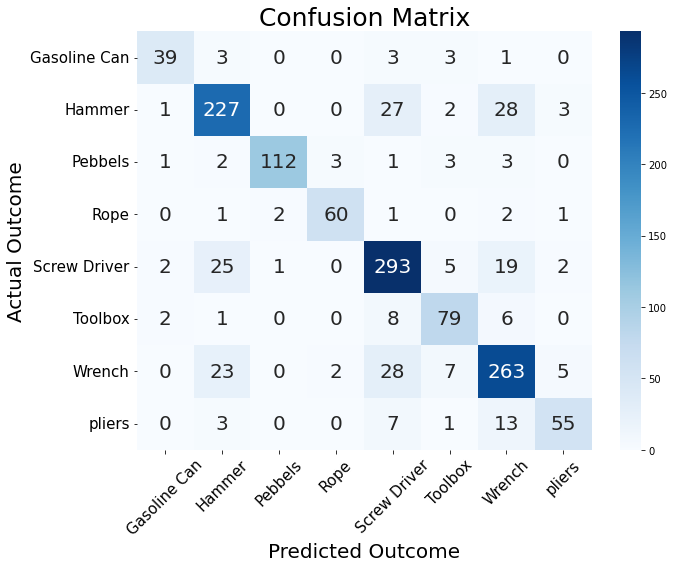

In [541]:
plt.figure(figsize=(10,8))
#plt.subplot(131)
ax = sns.heatmap(confusion_matrix(y_test,y_pred),
            annot = True, annot_kws={"size":20}, fmt="d",cmap = "Blues")

plt.title('Confusion Matrix', size=25)
plt.xlabel('Predicted Outcome', size=20)
plt.ylabel('Actual Outcome', size=20)
labels = [ int_category_map.get(key) for key in sorted(int_category_map.keys())]
ax.set_xticklabels(labels, size=15,rotation = 45)
ax.set_yticklabels(labels, size=15,rotation = 0)
plt.tight_layout()
plt.show();

In [501]:
X_incorrect = X_test[y_test != y_pred]
y_pred_incorrect = y_pred[y_test != y_pred]
y_test_incorrect = y_test[y_test != y_pred]
len(X_incorrect)

252

In [502]:
df = pd.read_csv("work_data_df",index_col = 0 )
df_test = df[df['class'] == "test"] 
pred_cate = [int_category_map.get(i) for i in y_pred]
df_test['pred_cate'] = pred_cate
df_test_incorrect = df_test[df_test.category != df_test.pred_cate]
df_test_incorrect

/var/folders/py/tfswslv1637f5tfr0ngkmsgr0000gn/T/ipykernel_5140/3250642109.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['pred_cate'] = pred_cate


,image_path,category,class,pred_cate
5,work_data/test/Gasoline Can/GasolineCan203.jpg,Gasoline Can,test,Screw Driver
12,work_data/test/Gasoline Can/GasolineCan216.jpg,Gasoline Can,test,Screw Driver
19,work_data/test/Gasoline Can/GasolineCan174.jpg,Gasoline Can,test,Toolbox
20,work_data/test/Gasoline Can/GasolineCan189.jpg,Gasoline Can,test,Toolbox
22,work_data/test/Gasoline Can/GasolineCan176.jpg,Gasoline Can,test,Screw Driver
...,...,...,...,...
1353,work_data/test/pliers/Pliers83.jpg,pliers,test,Hammer
1354,work_data/test/pliers/Pliers299.jpg,pliers,test,Wrench
1360,work_data/test/pliers/Pliers138.jpg,pliers,test,Wrench
1369,work_data/test/pliers/Pliers139.jpg,pliers,test,Wrench


#  Transfer learning with VGG16

In [526]:
vgg16_base = keras.applications.vgg16.VGG16(
                                            include_top= False, 
                                            weights='imagenet', 
                                            input_shape= (150,150,3))

### Freeze vgg16 parameters and exclude top layers

In [530]:
if os.path.exists("model_h5_file/vgg16_model_array.h5") == False:
    


    vgg16_base.trainable = False

    inputs = keras.Input(shape=(150, 150, 3))
    
    x = keras.applications.vgg16.preprocess_input(inputs)
    x = vgg16_base(x, training=False)

    x = Flatten()(x)
    x = keras.layers.Dense(32)(x)
    x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
    x = keras.layers.Dense(32)(x)
    x = keras.layers.Dropout(0.2)(x)
    outputs = keras.layers.Dense(8)(x)
    vgg16 = keras.Model(inputs, outputs)

    vgg16.summary()
   
    vgg16.compile(
        loss = keras.losses.SparseCategoricalCrossentropy(from_logits= True),
        optimizer = 'Adam',
        metrics=['accuracy'],
    )

    vgg16_result = vgg16.fit(train_ds,
                                validation_data= val_ds,
                                epochs=30, 
                                verbose=1,
                                batch_size =32,
                                callbacks = keras.callbacks.EarlyStopping(patience=5)) 

    vgg16.save("model_h5_file/vgg16_model_array.h5")
    
#     with open('vgg16_result.pickle','wb')as file:
#         pickle.dump(vgg16_result, file)

else: 
    vgg16 = keras.models.load_model('model_h5_file/vgg16_model_array.h5')
        
#     with open('vgg16_result.pickle','rb') as file:
#         vgg16_result = pickle.load(file)

In [288]:
#test_ds = IMG.ImageDataGenerator(rescale=1./255).flow(X_test, y_test, batch_size=1)

In [531]:
vgg16 = keras.models.load_model('model_h5_file/vgg16_model_array.h5')

y_pred = np.argmax(vgg16.predict(X_test),axis=1)

#y_pred = np.argmax(vgg16.predict(test_ds),axis=1)

In [532]:
print("accuracy :",accuracy_score(y_test, y_pred))
print('recall :',recall_score(y_test,y_pred,average = 'macro'))
print('precision :', precision_score(y_test,y_pred,average = 'macro'))
print('f1 :', f1_score(y_test,y_pred,average = 'macro'))

accuracy : 0.6918056562726613
recall : 0.6881877236709039
precision : 0.6835300777392442
f1 : 0.678469383068155


### Train VGG16 parameters

In [504]:
if os.path.exists('model_h5_file/vgg16_model_array_trainable.h5') == False:

    vgg16_base.trainable = True
    vgg16.summary()

    vgg16.compile(
                optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
                loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy']
                )
    
    vgg16_result = vgg16.fit(train_ds, 
                         validation_data = val_ds,
                         epochs = 100,
                         callbacks = keras.callbacks.EarlyStopping(patience=5),
                         verbose =1,
                         batch_size = 32)
    vgg16.save('vgg16_model_array_trainable.h5')

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_53 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 tf.__operators__.getitem_12  (None, 150, 150, 3)      0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_12 (TFOpLamb  (None, 150, 150, 3)      0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 8192)              0         
                                                                 
 dense_64 (Dense)            (None, 8)                 655

In [533]:
vgg16 = keras.models.load_model(model_h5_file/'vgg16_model_array_trainable.h5')
y_pred = np.argmax(vgg16.predict(X_test),axis=1)
print("accuracy :",accuracy_score(y_test, y_pred))
print('recall :',recall_score(y_test,y_pred,average = 'macro'))
print('precision :', precision_score(y_test,y_pred,average = 'macro'))
print('f1 :', f1_score(y_test,y_pred,average = 'macro'))

accuracy : 0.6519216823785352
recall : 0.6483713709924468
precision : 0.6388444541477268
f1 : 0.6388283506239494


## Transfer Learning with mobilenet_v2

In [544]:
mobilnetv2_base = keras.applications.mobilenet_v2.MobileNetV2(weights="imagenet", 
                                            input_shape=(150, 150, 3),
                                            include_top=False) 

mobilnetv2_base.trainable = False


if os.path.exists("mobilnetv2_base_array-.h5") == False:
    

    inputs = keras.Input(shape=(150, 150, 3))

    #x = data_augmentation(inputs)  # Apply random data augmentation
    
    x = keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = mobilnetv2_base(x, training=False)
    
    x = Flatten()(x)
    x = keras.layers.Dense(32)(x)
    x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
    x = keras.layers.Dense(32)(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(32)(x)
    x = keras.layers.Dropout(0.2)(x)
    outputs = keras.layers.Dense(8)(x)
    mobilnetv2 = keras.Model(inputs,outputs)

    mobilnetv2.summary()



    mobilnetv2.compile(
        #loss='categorical_crossentropy',
        loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer= keras.optimizers.Adam(learning_rate=0.0005),
        #optimizer = 'Adam',
        metrics=['accuracy'],
    )



    mobilnetv2_result = mobilnetv2.fit(train_ds,
                                validation_data= val_ds,
                                epochs=100, 
                                verbose=1, 
                                callbacks = keras.callbacks.EarlyStopping(patience=5))  # track progress as we fit

    mobilnetv2.save("model_h5_file/mobilnetv2_base_array.h5")
    with open('mobilnetv2_base.pickle','wb')as file:
        pickle.dump(Xception_result, file)

else: 
    mobilnetv2 = keras.models.load_model('model_h5_file/mobilnetv2_base_array.h5')
        
    with open('mobilnetv2_base.pickle','rb') as file:
        mobilnetv2_result = pickle.load(file)

Model: "model_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_74 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 tf.math.truediv_13 (TFOpLam  (None, 150, 150, 3)      0         
 bda)                                                            
                                                                 
 tf.math.subtract_13 (TFOpLa  (None, 150, 150, 3)      0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_16 (Flatten)        (None, 32000)             0         
                                                          

/Users/kristy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/Users/kristy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [545]:
y_pred = np.argmax(mobilnetv2.predict(X_test),axis =1)
print("accuracy :",accuracy_score(y_test, y_pred))
print('recall :',recall_score(y_test,y_pred,average = 'macro'))
print('precision :', precision_score(y_test,y_pred,average = 'macro'))
print('f1 :', f1_score(y_test,y_pred,average = 'macro'))

accuracy : 0.8143582306018854
recall : 0.8354748277086121
precision : 0.8203054926338201
f1 : 0.8255911179401066


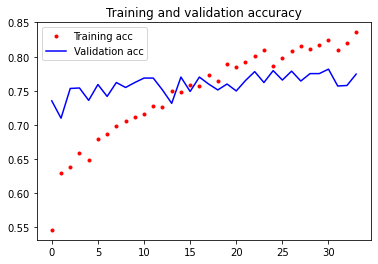

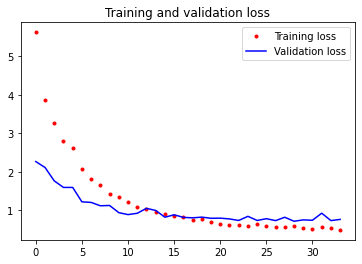

In [546]:
acc = mobilnetv2_result.history['accuracy']
val_acc = mobilnetv2_result.history['val_accuracy']
loss = mobilnetv2_result.history['loss']
val_loss = mobilnetv2_result.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r.', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

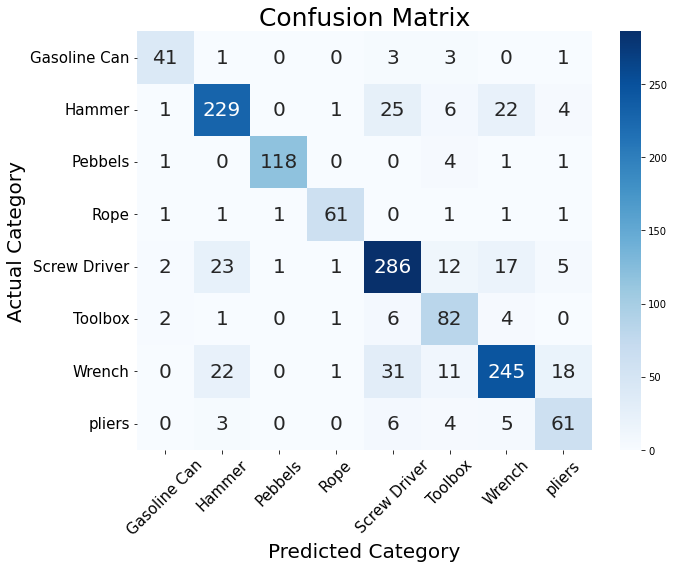

In [547]:
plt.figure(figsize=(10,8))
#plt.subplot(131)
ax = sns.heatmap(confusion_matrix(y_test,y_pred),
            annot = True, annot_kws={"size":20}, fmt="d",cmap = "Blues")

plt.title('Confusion Matrix', size=25)
plt.xlabel('Predicted Category', size=20)
plt.ylabel('Actual Category', size=20)
labels = [ int_category_map.get(key) for key in sorted(int_category_map.keys())]
ax.set_xticklabels(labels, size=15,rotation = 45)
ax.set_yticklabels(labels, size=15,rotation = 0)
plt.tight_layout()
plt.show();

### Train mobilnetv2 parameters

In [552]:
if os.path.exists('model_h5_file/mobilnetv2_trainable_array.h5') == False:

    mobilnetv2_base.trainable = True
    mobilnetv2.summary()

    mobilnetv2.compile(
        #loss='categorical_crossentropy',
        loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer= keras.optimizers.Adam(learning_rate=0.001),
        #optimizer = 'Adam',
        metrics=['accuracy'],
    )
    
    mobilnetv2_result = mobilnetv2.fit(train_ds, 
                         validation_data = val_ds,
                         epochs = 100,
                         callbacks = keras.callbacks.EarlyStopping(patience=2),
                         verbose =1,
                         batch_size = 32)
    mobilnetv2.save('model_h5_file/mobilnetv2_trainable_array.h5')

Model: "model_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_74 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 tf.math.truediv_13 (TFOpLam  (None, 150, 150, 3)      0         
 bda)                                                            
                                                                 
 tf.math.subtract_13 (TFOpLa  (None, 150, 150, 3)      0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_16 (Flatten)        (None, 32000)             0         
                                                          

In [551]:
y_pred = np.argmax(mobilnetv2.predict(X_test),axis =1)
print("accuracy :",accuracy_score(y_test, y_pred))
print('recall :',recall_score(y_test,y_pred,average = 'macro'))
print('precision :', precision_score(y_test,y_pred,average = 'macro'))
print('f1 :', f1_score(y_test,y_pred,average = 'macro'))

accuracy : 0.2516316171138506
recall : 0.125
precision : 0.03145395213923133
f1 : 0.05026071842410197


/Users/kristy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
